In [4]:
!python 3 

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [1]:
import pandas as pd
import numpy as np
import random
from datetime import timedelta

# Set random seed for reproducibility
np.random.seed(42)

# Define parameters
num_records = 30000
start_date = pd.to_datetime("2014-01-01")
end_date = pd.to_datetime("2024-01-01")
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Generate synthetic dates for transactions
dates = np.random.choice(date_range, size=num_records)

# Sort dates to simulate chronological transactions
dates = np.sort(dates)

# Generate random senders
senders = ['Alice', 'Bob', 'Charlie', 'David', 'Eve']
sender = np.random.choice(senders, size=num_records)

# Generate transaction amounts with skew: small transactions more common, few large transactions
transaction_amount = np.random.exponential(scale=200, size=num_records).round(2)  # Scale affects avg transaction size

# Generate balance as a cumulative sum of random walk based on transaction amounts
initial_balance = 1000  # Starting balance
balance = np.cumsum(np.random.normal(loc=0, scale=100, size=num_records)) + initial_balance
balance = np.clip(balance, a_min=0, a_max=None)  # Ensure balance is non-negative

# Generate transaction type (e.g., withdrawal, deposit)
transaction_types = ['withdrawal', 'deposit']
transaction_type = np.random.choice(transaction_types, size=num_records)

# Create DataFrame
df = pd.DataFrame({
    'date': dates,
    'sender': sender,
    'transaction_amount': transaction_amount,
    'balance': balance,
    'transaction_type': transaction_type
})

# Sort by date to ensure transactions are ordered
df = df.sort_values(by='date').reset_index(drop=True)

# Display first few rows of generated data
print(df.head())

# Save to CSV if needed
df.to_csv('synthetic_bank_transactions.csv', index=False)


        date sender  transaction_amount     balance transaction_type
0 2014-01-01    Eve               66.71  760.819395       withdrawal
1 2014-01-01    Eve               11.30  781.403659          deposit
2 2014-01-01  David               64.41  728.597756          deposit
3 2014-01-01  Alice              512.52  520.091756       withdrawal
4 2014-01-01  Alice               41.55  406.602809       withdrawal


In [16]:
df.isnull().sum()

date                           0
transaction_amount             0
balance                        0
day_of_week                    0
month                          0
day                            0
sender_Alice                   0
sender_Bob                     0
sender_Charlie                 0
sender_David                   0
sender_Eve                     0
transaction_type_deposit       0
transaction_type_withdrawal    0
dtype: int64

In [8]:
df.shape

NameError: name 'df' is not defined

In [6]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.0 MB 2.4 MB/s eta 0:00:05
   ---- ----------------------------------- 1.3/11.0 MB 2.5 MB/s eta 0:00:04
   ------- -------------------------------- 2.1/11.0 MB 2.7 MB/s eta 0:00:04
   --------- ------------------------------ 2.6/11.0 MB 2.7 MB/s eta 0:00:04
   ----------- ---------------------------- 3.1/11.0 MB 2.8 MB/s eta 0:00:03
   ------------- -------------------------- 3.7/11.0 MB 2.7 MB/s eta 0:00:03
   ---------------- ----------------------- 4.5/11.0 MB 2.8 MB/s eta 0:00:03
   ------------------ --------------------- 5.0/11.0 MB 2.8 MB/s eta 0:00:03
   -------------------- ----------


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\abrah\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocesssing import OneHotencoding
# Load data
df = pd.read_csv('synthetic_bank_transactions.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Create date-based features
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# One-hot encode categorical feature (sender)
df = pd.get_dummies(df, columns=['sender','transaction_type'])

# Scale numerical features
scaler = MinMaxScaler()
df[['transaction_amount', 'balance']] = scaler.fit_transform(df[['transaction_amount', 'balance']])

# Convert DataFrame to numpy array after preprocessing to simplify indexing
data = df.drop(columns=['date']).values

# Prepare sequences function with fixed indexing
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        # Get the sequence of data for the current window
        sequence = data[i:i + window_size]
        # Get the target value (transaction_amount) at the end of the current window
        target = data[i + window_size, 0]  # Assuming 'transaction_amount' is the first column after drop
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Define window size
window_size = 30
X, y = create_sequences(data, window_size)


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np

# Load data
df = pd.read_csv('synthetic_bank_transactions.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Create date-based features
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# Apply OneHotEncoder for categorical columns
encoder = OneHotEncoder(sparse=False, drop='first')  # `drop='first'` avoids dummy variable trap

# Encode 'sender' and 'transaction_type' separately and then add to df
encoded_features = encoder.fit_transform(df[['sender', 'transaction_type']])
encoded_feature_names = encoder.get_feature_names_out(['sender', 'transaction_type'])

# Create a DataFrame from the encoded features and concatenate with the original DataFrame
df_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)
df = pd.concat([df, df_encoded], axis=1).drop(columns=['sender', 'transaction_type'])

# Scale numerical features
scaler = MinMaxScaler()
df[['transaction_amount', 'balance']] = scaler.fit_transform(df[['transaction_amount', 'balance']])

# Convert DataFrame to numpy array after preprocessing to simplify indexing
data = df.drop(columns=['date']).values

# Prepare sequences function with fixed indexing
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        # Get the sequence of data for the current window
        sequence = data[i:i + window_size]
        # Get the target value (transaction_amount) at the end of the current window
        target = data[i + window_size, 0]  # Assuming 'transaction_amount' is the first column after drop
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Define window size
window_size = 30
X, y = create_sequences(data, window_size)


In [7]:
X[0][0]

array([0.0364007465700346, 0.07176443526857695, 2, 1, 1, False, False,
       False, False, True, False, True], dtype=object)

(array([1.7864e+04, 7.1830e+03, 2.9360e+03, 1.2100e+03, 4.9300e+02,
        1.8200e+02, 6.1000e+01, 2.5000e+01, 1.1000e+01, 5.0000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

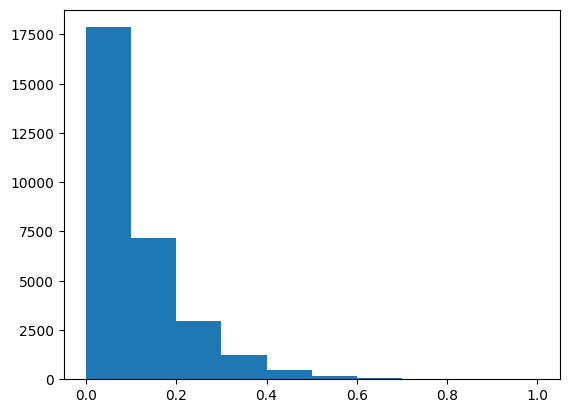

In [3]:
import matplotlib.pyplot as plt
plt.hist(y)

In [33]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\abrah\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [31]:
y

array([0.09700499, 0.11356815, 0.19665681, ..., 0.02600443, 0.00921206,
       0.00959408])

In [41]:
import random

In [8]:
import numpy as np

X = np.array(X, dtype=np.float32)  # Ensuring X is a NumPy array of floats
y = np.array(y, dtype=np.float32)  # Ensuring y is a NumPy array of floats


In [4]:
num_features = X.shape[2]
X = X.reshape((X.shape[0], X.shape[1], num_features))


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(window_size, num_features)))
model.add(Dropout(0.2))
model.add(Dense(1))  # Predicting one value (next transaction amount)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, y, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 14.9118
Epoch 2/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0126
Epoch 3/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0126
Epoch 4/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0124
Epoch 5/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0125
Epoch 6/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0122
Epoch 7/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0123
Epoch 8/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0122
Epoch 9/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0122
Epoch 10/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0121
Epoch 11/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0120
Epoch 12/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0120
Epoch 13/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0120
Epoch 14/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0147
Epoch 15/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - 

In [46]:
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl (7.5 kB)
Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl (390.3 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\abrah\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\abrah\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [11]:
# Number of future predictions you want
n_future = 90  # Predicting the next 90 transactions, for example

# Initialize an array to store future predictions
future_predictions = []

# Take the last sequence from the training data to start predicting future values
current_sequence = X[-1]  # Last sequence from X

for _ in range(n_future):
    # Predict the next value
    next_value = model.predict(current_sequence.reshape(1, window_size, num_features))[0, 0]
    future_predictions.append(next_value)
    
    # Create a placeholder for the next sequence
    next_sequence = np.append(current_sequence[1:], [[next_value] + [0] * (num_features - 1)], axis=0)
    
    # Update the current sequence
    current_sequence = next_sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [13]:
# Reshape future_predictions for inverse scaling
future_predictions = np.array(future_predictions).reshape(-1, 1)

# Create an array with the same shape as the scaler's input
# Fill it with zeros for columns other than 'transaction_amount'
filler_array = np.zeros((future_predictions.shape[0], 2))  # Assuming two columns: 'transaction_amount' and 'balance'
filler_array[:, 0] = future_predictions[:, 0]  # Place predictions in the 'transaction_amount' column

# Perform inverse scaling
future_predictions_rescaled = scaler.inverse_transform(filler_array)

# Extract the rescaled 'transaction_amount' column only
future_transaction_amounts = future_predictions_rescaled[:, 0]


In [15]:
from scipy.stats import linregress
import numpy as np

# Ensure y_values only contains 90 values (one for each future prediction)
y_values = future_transaction_amounts.flatten()[:n_future]  # Ensure we use only n_future values
x_values = np.arange(n_future)  # Days or sequence indices

# Calculate slope for trend analysis
slope, intercept, _, _, _ = linregress(x_values, y_values)
trend = "Positive" if slope > 0 else "Negative"

print(f"The trend of future transactions is: {trend}")


The trend of future transactions is: Positive


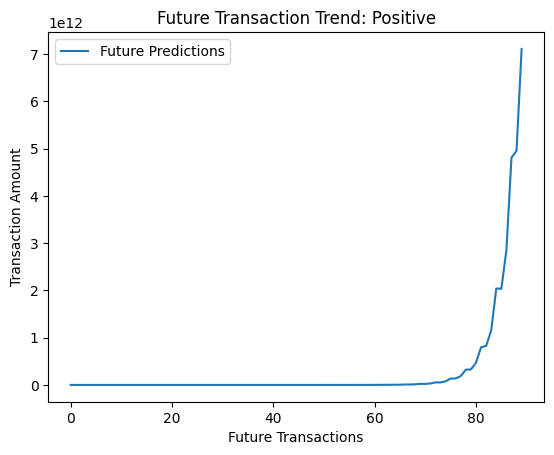

In [16]:
import matplotlib.pyplot as plt

# Plot future predictions
plt.plot(y_values, label="Future Predictions")
plt.title(f"Future Transaction Trend: {trend}")
plt.xlabel("Future Transactions")
plt.ylabel("Transaction Amount")
plt.legend()
plt.show()

In [ ]:
past_transactions_rescaled = scaler.inverse_transform(df[['transaction_amount', 'balance']])[:, 0]

# Create a combined array for past and future transactions
combined_transactions = np.concatenate((past_transactions_rescaled[-window_size:], y_values))

# Plot combined past and future transactions
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(past_transactions_rescaled[-window_size:])), past_transactions_rescaled[-window_size:], label="Past Transactions", color="green")
plt.plot(np.arange(len(past_transactions_rescaled[-window_size:]), len(combined_transactions)), y_values, label="Future Predictions", color="blue")
plt.axvline(x=window_size - 1, color="red", linestyle="--", label="Prediction Start")
plt.title("Combined Past and Future Transaction Amounts")
plt.xlabel("Transactions")
plt.ylabel("Transaction Amount")
plt.legend()

In [35]:
import yaml
from yaml.loader import SafeLoader

with open(r"E:\poc_files\credentials.yaml") as file:
    config=yaml.load(file,Loader=SafeLoader)

authenticator=stauth.Authenticate(
    config['credentials'],
    config['cookie']['name'],
    config['cookie']['key'],
    config['cookie']['expiry_days'])

2024-11-12 09:48:15.850 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-12 09:48:15.851 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-12 09:48:16.058 
  command:

    streamlit run C:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2024-11-12 09:48:16.058 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-12 09:48:16.511 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-12 09:48:16.511 Session state does not function when running a script without `streamlit run`
2024-11-12 09:48:16.511 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when

In [31]:
import streamlit_authenticator as stauth

# Pass the list of passwords directly to the 
# Hasher constructor and generate the hashes
# passwords_to_hash = ['fashion@123', 'increff@fashion']
hashed_passwords = stauth.Hasher( ['fashion@123', 'increff@fashion']).generate()

print(hashed_passwords)

AttributeError: 'Hasher' object has no attribute 'generate'

In [29]:
%pip install streamlit-authenticator==0.1.5

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for streamlit-authenticator: filename=streamlit_authenticator-0.1.5-py3-none-any.whl size=5289 sha256=d26ef2045b9972a421d7839dd96d617ba51f230c856c0ed961009b496b0fb64c
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\67\6d\d2\dfda3c9580bac9ef9b453e9350abe9faf3db19b9910f4c1816
Successfully built streamlit-authenticator
  Attempting uninstall: streamlit-authenticator
    Found existing installation: streamlit-authenticator 0.4.1
    Uninstalling streamlit-authenticator-0.4.1:
      Successfully uninstalled streamlit-authenticator-0.4.1
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import pickle
from pathlib import Path
import streamlit as st
import streamlit_authenticator as stauth
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

# 1. Setting up user authentication
# Define your usernames, passwords, and names

# Define your usernames, passwords, and names
usernames = ["abraham1", "ziegen2"]
passwords = ["asdf23", "jkl;90"]
names = ["abraham", "ziegen"]
# Hash the passwords using the new syntax
hashed_passwords = stauth.Hasher(passwords).generate()  # New way to generate hashed passwords

# Initialize the authenticator with user data
authenticator = stauth.Authenticate(
    names=names,
    usernames=usernames,
    hashed_passwords=hashed_passwords,
    cookie_name="my_app_cookie_name",
    key="my_app_signature_key",
    cookie_expiry_days=30
)

# Create the login widget
name, authentication_status, username = authenticator.login("Login", "main")

if authentication_status:
    st.title("Future Transactions Trend Analysis")

    # Load and preprocess data
    df = pd.read_csv('synthetic_bank_transactions.csv')
    df['date'] = pd.to_datetime(df['date'])

    # Assuming preprocessing and model prediction are here...
    n_future = 90
    future_predictions = np.random.rand(n_future)  # Replace with actual predictions

    # Plotting predictions
    x_values = np.arange(n_future)
    y_values = future_predictions.flatten()
    slope, intercept, _, _, _ = linregress(x_values, y_values)
    trend = "Positive" if slope > 0 else "Negative"

    st.subheader(f"Predicted Trend: {trend}")
    fig, ax = plt.subplots()
    ax.plot(x_values, y_values, label="Future Predictions")
    ax.set_xlabel("Days")
    ax.set_ylabel("Transaction Amount")
    ax.legend()
    st.pyplot(fig)

    authenticator.logout("Logout", "sidebar")
    
elif authentication_status == False:
    st.error("Username/password is incorrect")

elif authentication_status == None:
    st.warning("Please enter your username and password")


TypeError: Authenticate.__init__() missing 1 required positional argument: 'credentials'

In [23]:
%pip install streamlit streamlit-authenticator



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import streamlit_authenticator as stauth

# List of plaintext passwords
passwords = ["asdf23rda", "lklkkm23"]

# Generate hashed passwords
hashed_passwords = stauth.Hasher(passwords).generate()
print(hashed_passwords)


AttributeError: 'Hasher' object has no attribute 'generate'